In [1]:
import pandas as pd

import torch
from torch import nn
from transformers import LongformerForTokenClassification, LongformerTokenizer, AutoModel


from torch.utils.data import Dataset,DataLoader

from tqdm import tqdm

In [2]:
tokenized_df = pd.read_pickle('../data/preprocess_step2.pkl')

lens = [len(elem) for elem in tokenized_df['tokens']]
avg_len = sum(lens)/len(lens)

print(avg_len)

457.47390021803255


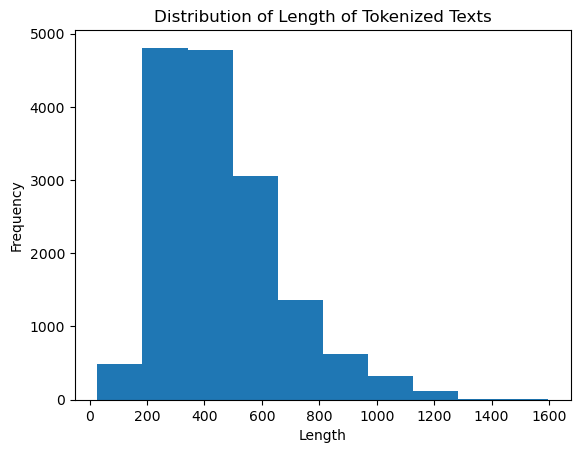

In [3]:
import matplotlib.pyplot as plt
plt.hist(lens, bins=10)  # Adjust the number of bins as needed
plt.title('Distribution of Length of Tokenized Texts')
plt.xlabel('Length')
plt.ylabel('Frequency')
plt.show()

In [4]:
tokenized_df_cleaned = tokenized_df[tokenized_df["tokens"].apply(lambda x: len(x)<=600)]

longest_list = max(tokenized_df_cleaned['tokens'], key=len)
print("Number of token:", len(longest_list))


all_labels = [item for sublist in tokenized_df['aligned_tags'] for item in sublist]
unique_labels = set(all_labels)  
print(unique_labels)
print(len(tokenized_df_cleaned))

Number of token: 600
{'Rebuttal', 'Claim', 'Concluding Statement', 'Counterclaim', 'Position', 'Lead', 'Evidence'}
12308


In [5]:
# Encoding Text and Labels

tokenizer = LongformerTokenizer.from_pretrained('allenai/longformer-base-4096')

labels = ['Claim', 'Evidence', 'Concluding Statement', 'Rebuttal', 'Position','Counterclaim', 'Lead']

input_ids = [tokenizer.convert_tokens_to_ids(tokens) for tokens in tokenized_df_cleaned['tokens']]
input_labels = [[labels.index(l) for l in tags] for tags in tokenized_df_cleaned['aligned_tags']]


In [6]:
MAX_LENGTH = len(longest_list) + 5

def pad_sequences(sequences, max_len, padding_value=0):
    return [seq + [padding_value] * (max_len - len(seq)) if len(seq) < max_len else seq[:max_len] for seq in sequences]

padded_input_ids = pad_sequences(input_ids, MAX_LENGTH, padding_value=tokenizer.pad_token_id)

padded_input_labels = pad_sequences(input_labels, MAX_LENGTH, padding_value=-100)

attention_masks = [[float(token_id != tokenizer.pad_token_id) for token_id in seq] for seq in padded_input_ids]


In [7]:
if torch.cuda.is_available():
    device = torch.device("cuda")

else:
    if not torch.backends.mps.is_available():
        if not torch.backends.mps.is_built():
            print("MPS not available because the current PyTorch install was not "
                "built with MPS enabled.")      
        else:
            print("MPS not available because the current MacOS version is not 12.3+ "
                "and/or you do not have an MPS-enabled device on this machine.")
        device = torch.device("cpu")

    else:
        device = torch.device("mps")

print(device)

cuda


In [8]:
class EssayDataset(Dataset):
    def __init__(self, input_ids, attention_masks, labels):
        self.input_ids = input_ids
        self.attention_masks = attention_masks
        self.labels = labels

    def __getitem__(self, idx):
        return {
            'input_ids': torch.tensor(self.input_ids[idx], dtype=torch.long).to(device),
            'attention_mask': torch.tensor(self.attention_masks[idx], dtype=torch.long).to(device),
            'labels': torch.tensor(self.labels[idx], dtype=torch.long).to(device)
        }

    def __len__(self):
        return len(self.input_ids)
    

ds = EssayDataset(padded_input_ids, attention_masks, padded_input_labels)

In [9]:
batch_size = 16

from torch.utils.data import random_split

# Define the sizes for train, validation, and test sets
total_size = len(ds)
train_size = int(0.8 * total_size)
val_size = int(0.1 * total_size)
test_size = total_size - train_size - val_size

# Split the dataset
train_ds, val_ds, test_ds = random_split(ds, [train_size, val_size, test_size])

# Create data loaders for each set
train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_ds, batch_size=batch_size, shuffle=False) 
test_loader = DataLoader(test_ds, batch_size=batch_size, shuffle=False)

In [10]:
num_labels = len(unique_labels)

In [11]:
import torch
from torch import nn

class EssayDisectionModel(nn.Module):
    def __init__(self, num_labels=7, hidden_size=768):
        super(EssayDisectionModel, self).__init__()
        
        self.backbone = AutoModel.from_pretrained(
        'allenai/longformer-base-4096',
        num_labels=num_labels
        )
        
        self.dense1 = nn.Linear(hidden_size, 256)
        self.relu = nn.ReLU()
        self.dense2 = nn.Linear(256, num_labels)

    def forward(self, input_ids, attention_mask):
        backbone_output = self.backbone(input_ids=input_ids, attention_mask=attention_mask)
        # x = backbone_output.logits.view(-1, self.backbone.config.hidden_size)
        
        x = self.dense1(backbone_output[0])
        x = self.relu(x)
        x = self.dense2(x)
        
        return x

model = EssayDisectionModel()

# model = LongformerForTokenClassification.from_pretrained('allenai/longformer-base-4096',
#         num_labels=7)

In [12]:
torch.cuda.empty_cache()

100%|██████████| 10/10 [1:10:25<00:00, 422.50s/it]


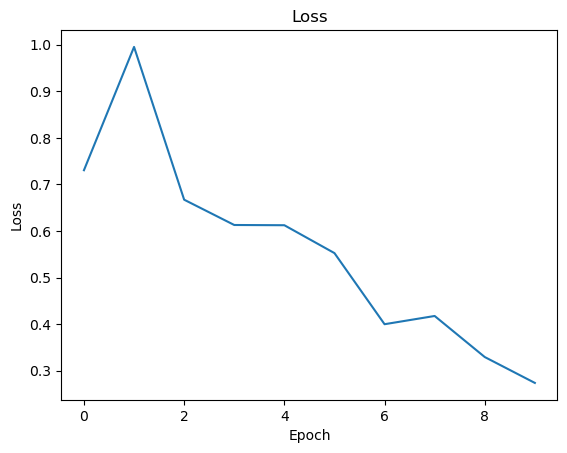

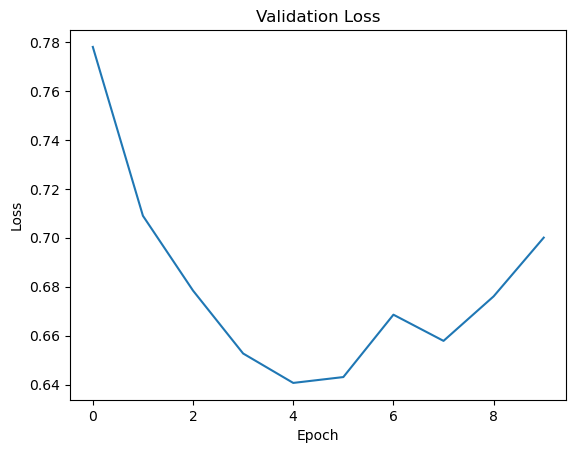

In [13]:
import matplotlib.pyplot as plt
from torch.optim.lr_scheduler import StepLR

num_epochs = 10
losses = []
val_losses = []

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = nn.DataParallel(model, device_ids=[0, 1])
model.to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=1e-5)
loss_fn = nn.CrossEntropyLoss(ignore_index=-100)
scaler = torch.cuda.amp.GradScaler()
scheduler = StepLR(optimizer, step_size=1, gamma=0.1)


for epoch in tqdm(range(num_epochs)):
    model.train()
    for batch in train_loader:

        input_seq_batch = batch['input_ids']
        target_seq_batch = batch['labels']
        attention_mask = batch['attention_mask']
    
        with torch.cuda.amp.autocast():
            target_seq_hat = model(input_seq_batch, attention_mask)
            target_seq_hat = target_seq_hat.view(-1, target_seq_hat.shape[-1])
            target_seq_batch = target_seq_batch.view(-1)
            loss = loss_fn(target_seq_hat, target_seq_batch)

        optimizer.zero_grad()
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()
        # scheduler.step()
        

        # input_seq_batch = batch['input_ids']
        # target_seq_batch = batch['labels']
        # attention_mask = batch['attention_mask']
    
        # optimizer.zero_grad()

        # target_seq_hat = model(input_seq_batch, attention_mask)

        # target_seq_hat = target_seq_hat.view(-1, target_seq_hat.shape[-1])  # [batch_size * sequence_size, num_labels]
        # target_seq_batch = target_seq_batch.view(-1)

        # loss = loss_fn(target_seq_hat, target_seq_batch)

        # loss.backward()

        # optimizer.step()
        
    losses.append(loss.item())


    model.eval()
    total_val_loss = 0
    num_batches = 0
    with torch.no_grad():
        for batch in val_loader:

            input_seq_batch = batch['input_ids']
            target_seq_batch = batch['labels']
            attention_mask = batch['attention_mask']

            outputs = model(input_seq_batch, attention_mask)

            loss = loss_fn(outputs.view(-1, outputs.shape[-1]), target_seq_batch.view(-1))
            total_val_loss += loss.item()
            num_batches += 1

        average_val_loss = total_val_loss / num_batches
        val_losses.append(average_val_loss)
    

# Plotting the training losses
plt.title('Loss')
plt.plot(losses)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

plt.title('Validation Loss')
plt.plot(val_losses)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()


In [14]:
total, correct, predictions = 0,0, []


model.eval()
with torch.no_grad():
    for batch in test_loader:
        inputs = batch['input_ids']
        mask = batch['attention_mask']
        targets = batch['labels']
        outputs = model(inputs, mask)
        pred = outputs.argmax(dim=-1)
        correct_predictions = (pred == targets)
        masked_correct_predictions = correct_predictions & mask.bool()
        correct += masked_correct_predictions.sum().item()
        total += mask.sum().item()

accuracy = correct/total

print(f"current accuracy: {accuracy*100}%")

current accuracy: 67.65882499296148%


In [15]:
print(total) 
print(correct)

458193
310008


In [16]:
torch.save(model, '../data/model.pth')